In [1]:
import tensorflow as tf

print(tf.__version__)

1.14.0


In [2]:
# 이후 작업을 위해 TF 2.0 설치
# !pip install tensorflow==2.0.0-beta1 

     |████████████████████████████████| 87.9MB 1.4MB/s 
     |████████████████████████████████| 3.1MB 47.0MB/s 
     |████████████████████████████████| 501kB 42.2MB/s 
  Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-1.14.0


In [1]:
import tensorflow as tf

print(tf.__version__)

2.0.0-beta1


In [0]:
# TF 2.0에서는 필요 없음
# 기존의 세션에 feeding 하던 기능을 즉시 실행할 수 있도록 해주는 작업
# tf.enable_eager_execution()

## IMDB 데이터를 이용한 감성분석...?

In [0]:
# 데이터셋
# !pip install tensorflow-datasets
import tensorflow_datasets as tfds

In [0]:
# 윈도우에서 문제 있어보임
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

In [0]:
import numpy as np

In [0]:
train_data, test_data = imdb['train'], imdb['test']

In [0]:
# 학습용 데이터
training_sentences = []
training_labels = []

# 테스트용 데이터
testing_sentences = []
testing_labels = []

In [8]:
# 데이터 확인
for s, l in train_data:
  print("Sentence: ", s)
  print("Label:", l)
  print(type(s))
  print(type(s.numpy()))
  print(type(str(s.numpy())))
  break

Sentence:  tf.Tensor(b'I have no idea what the other reviewer is talking about- this was a wonderful movie, and created a sense of the era that feels like time travel. The characters are truly young, Mary is a strong match for Byron, Claire is juvenile and a tad annoying, Polidori is a convincing beaten-down sycophant... all are beautiful, curious, and decadent... not the frightening wrecks they are in Gothic.<br /><br />Gothic works as an independent piece of shock film, and I loved it for different reasons, but this works like a Merchant and Ivory film, and was from my readings the best capture of what the summer must have felt like. Romantic, yes, but completely rekindles my interest in the lives of Shelley and Byron every time I think about the film. One of my all-time favorites.', shape=(), dtype=string)
Label: tf.Tensor(1, shape=(), dtype=int64)
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'bytes'>
<class 'str'>


In [0]:
# 학습데이터와 테스트 데이터의 전처리(토크나이징, 패딩 등)를 하기 위한 작업
for s, l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())
  
for s, l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())
  

training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [10]:
print(type(training_labels))
print(type(training_labels_final))

<class 'list'>
<class 'numpy.ndarray'>


## 전처리 작업

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [0]:
# 설정 값 정의
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = '<OOV>'

In [0]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, truncating=trunc_type)

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 11526     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [20]:
num_epochs = 10
model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 3s 138us/sample - loss: 0.4991 - accuracy: 0.7463 - val_loss: 0.4173 - val_accuracy: 0.8062
Epoch 2/10
25000/25000 [==============================] - 3s 130us/sample - loss: 0.2417 - accuracy: 0.9086 - val_loss: 0.4101 - val_accuracy: 0.8203
Epoch 3/10
25000/25000 [==============================] - 3s 129us/sample - loss: 0.0928 - accuracy: 0.9770 - val_loss: 0.5125 - val_accuracy: 0.8104
Epoch 4/10
25000/25000 [==============================] - 3s 130us/sample - loss: 0.0274 - accuracy: 0.9966 - val_loss: 0.5802 - val_accuracy: 0.8083
Epoch 5/10
25000/25000 [==============================] - 3s 133us/sample - loss: 0.0117 - accuracy: 0.9985 - val_loss: 0.6547 - val_accuracy: 0.8076
Epoch 6/10
25000/25000 [==============================] - 3s 130us/sample - loss: 0.0062 - accuracy: 0.9991 - val_loss: 0.7140 - val_accuracy: 0.8032
Epoch 7/10
25000/25000 [==========================

In [21]:
e = model.layers[0]
weights = e.get_weights()[0]

weights.shape

(10000, 16)

In [0]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [0]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

## 다음에서 Word2Vec 확인하기
[TensorBoard](http://projector.tensorflow.org/)

# Sarcasm dataset classification

In [0]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [0]:
# 설정 값 정의
vocab_size = 10000
embedding_dim = 16
max_length = 32
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_size = 20000

In [27]:
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json -O /content/sarcasm.json

--2019-07-08 02:07:17--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.197.144, 2404:6800:4004:818::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.197.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/content/sarcasm.json’

/content/sarcasm.js 100%[===================>]   5.38M  --.-KB/s    in 0.08s   

2019-07-08 02:07:17 (67.3 MB/s) - ‘/content/sarcasm.json’ saved [5643545/5643545]



In [0]:
with open("/content/sarcasm.json", 'r') as f:
  datastore = json.load(f)

In [0]:
sentences = []
labels = []

for item in datastore:
  sentences.append(item['headline'])
  labels.append(item['is_sarcastic'])

In [30]:
sentences[:5]

["former versace store clerk sues over secret 'black code' for minority shoppers",
 "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
 "mom starting to fear son's web series closest thing she will have to grandchild",
 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas',
 'j.k. rowling wishes snape happy birthday in the most magical way']

In [31]:
labels[:5]

[0, 0, 1, 1, 0]

In [0]:
training_sentences = sentences[:training_size]
testing_sentences = sentences[training_size:]

training_labels = labels[:training_size]
testing_labels = labels[training_size:]

In [33]:
print(len(training_sentences))
print(len(training_labels))

print(len(testing_sentences))
print(len(testing_labels))

20000
20000
6709
6709


In [0]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, truncating=trunc_type)

In [39]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(), # tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 32, 16)            160000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [40]:
num_epochs = 30

history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Train on 20000 samples, validate on 6709 samples
Epoch 1/30
20000/20000 - 2s - loss: 0.5603 - acc: 0.7006 - val_loss: 0.3942 - val_acc: 0.8329
Epoch 2/30
20000/20000 - 2s - loss: 0.3078 - acc: 0.8751 - val_loss: 0.3428 - val_acc: 0.8551
Epoch 3/30
20000/20000 - 2s - loss: 0.2299 - acc: 0.9094 - val_loss: 0.3475 - val_acc: 0.8505
Epoch 4/30
20000/20000 - 2s - loss: 0.1846 - acc: 0.9299 - val_loss: 0.3658 - val_acc: 0.8527
Epoch 5/30
20000/20000 - 2s - loss: 0.1526 - acc: 0.9439 - val_loss: 0.4005 - val_acc: 0.8468
Epoch 6/30
20000/20000 - 2s - loss: 0.1291 - acc: 0.9538 - val_loss: 0.4309 - val_acc: 0.8456
Epoch 7/30
20000/20000 - 2s - loss: 0.1083 - acc: 0.9631 - val_loss: 0.4753 - val_acc: 0.8419
Epoch 8/30
20000/20000 - 2s - loss: 0.0938 - acc: 0.9682 - val_loss: 0.5389 - val_acc: 0.8326
Epoch 9/30
20000/20000 - 2s - loss: 0.0817 - acc: 0.9730 - val_loss: 0.5715 - val_acc: 0.8316
Epoch 10/30
20000/20000 - 2s - loss: 0.0696 - acc: 0.9780 - val_loss: 0.6237 - val_acc: 0.8296
Epoch 11/3

In [0]:
import matplotlib.pyplot as plt

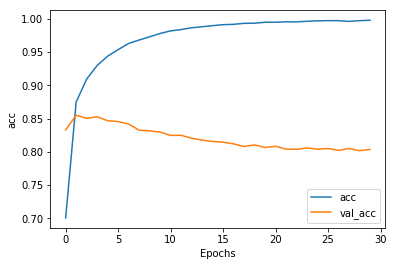

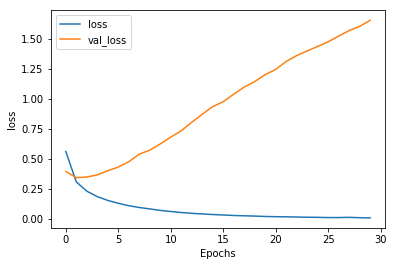

In [42]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "acc")
plot_graphs(history, "loss")
  

# Subword를 이용한 학습

In [0]:
import tensorflow_datasets as tfds

In [0]:
imdb, info = tfds.load("imdb_reviews/subwords8k", with_info=True, as_supervised=True)

In [50]:
info.features

FeaturesDict({'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8185>), 'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2)})

In [0]:
train_data, test_data = imdb['train'], imdb['test']

In [46]:
tokenizer = info.features['text'].encoder
tokenizer

<SubwordTextEncoder vocab_size=8185>

In [0]:
tokenizer.subwords

In [51]:
sample_string = "TensorFlow, from basics to mastery"

tokenized_string = tokenizer.encode(sample_string)
print("Tokenized string is", tokenized_string)

original_string = tokenizer.decode(tokenized_string)
print("The original string:", original_string)

Tokenized string is [6307, 2327, 4043, 2120, 2, 48, 4249, 4429, 7, 2652, 8050]
The original string: TensorFlow, from basics to mastery


In [54]:
for ts in tokenized_string:
  print("{:>4} ----> {}".format(ts, tokenizer.decode([ts])))

6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
   2 ----> , 
  48 ----> from 
4249 ----> basi
4429 ----> cs 
   7 ----> to 
2652 ----> master
8050 ----> y


In [55]:
embedding_dim = 64

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 24)                1560      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 25        
Total params: 525,425
Trainable params: 525,425
Non-trainable params: 0
_________________________________________________________________


In [56]:
# 꽤 오랜 시간이 걸림
num_epochs = 10

history = model.fit(train_data, epochs=num_epochs, validation_data=test_data)

Epoch 1/10
25000/25000 [==============================] - 360s 14ms/step - loss: 0.6846 - acc: 0.5389 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/10
25000/25000 [==============================] - 180s 7ms/step - loss: 0.6826 - acc: 0.5441 - val_loss: 0.6836 - val_acc: 0.5407
Epoch 3/10
25000/25000 [==============================] - 180s 7ms/step - loss: 0.6820 - acc: 0.5453 - val_loss: 0.6839 - val_acc: 0.5408
Epoch 4/10
25000/25000 [==============================] - 180s 7ms/step - loss: 0.6813 - acc: 0.5463 - val_loss: 0.6847 - val_acc: 0.5399
Epoch 5/10
25000/25000 [==============================] - 180s 7ms/step - loss: 0.6806 - acc: 0.5471 - val_loss: 0.6858 - val_acc: 0.5393
Epoch 6/10
25000/25000 [==============================] - 180s 7ms/step - loss: 0.6801 - acc: 0.5479 - val_loss: 0.6861 - val_acc: 0.5391
Epoch 7/10
25000/25000 [==============================] - 180s 7ms/step - loss: 0.6796 - acc: 0.5486 - val_loss: 0.6870 - val_acc: 0.5387
Epoch 8/10
25000/25000 [=

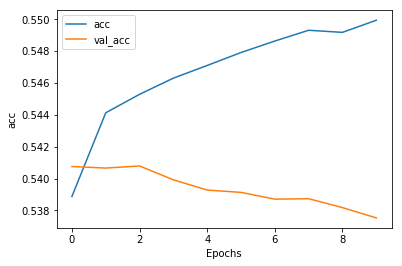

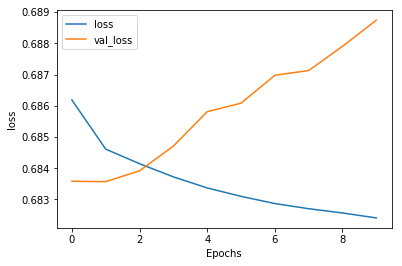

In [57]:
plot_graphs(history, "acc")
plot_graphs(history, "loss")

# Naver sentiment movie corpus
- [Github](https://github.com/e9t/nsmc/)

In [58]:
!git clone https://github.com/e9t/nsmc/

Cloning into 'nsmc'...
remote: Enumerating objects: 14763, done.
remote: Total 14763 (delta 0), reused 0 (delta 0), pack-reused 14763
Receiving objects: 100% (14763/14763), 56.19 MiB | 17.21 MiB/s, done.
Resolving deltas: 100% (1749/1749), done.
Checking out files: 100% (14737/14737), done.


In [0]:
import pandas as pd

In [81]:
train = pd.read_csv("nsmc/ratings_train.txt", sep="\t")
test = pd.read_csv("nsmc/ratings_test.txt", sep="\t")
test

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
5,7898805,"음악이 주가 된, 최고의 음악영화",1
6,6315043,진정한 쓰레기,0
7,6097171,"마치 미국애니에서 튀어나온듯한 창의력없는 로봇디자인부터가,고개를 젖게한다",0
8,8932678,갈수록 개판되가는 중국영화 유치하고 내용없음 폼잡다 끝남 말도안되는 무기에 유치한c...,0
9,6242223,"이별의 아픔뒤에 찾아오는 새로운 인연의 기쁨 But, 모든 사람이 그렇지는 않네..",1


In [0]:
train_sentences = train["document"].values
train_sentences = train_sentences.astype(str)
train_sentences.tolist()
train_labels = train["label"].values

test_sentences = test["document"].values
test_sentences = test_sentences.astype(str)
test_sentences.tolist()
test_labels = test["label"].values

In [0]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [0]:
# 설정 값 정의
vocab_size = 10000
embedding_dim = 16
max_length = 32
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_size = len(train)
test_size = len(test)

In [0]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(train_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(test_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, truncating=trunc_type)

In [100]:
word_index

{'<OOV>': 1,
 '영화': 2,
 '너무': 3,
 '정말': 4,
 '진짜': 5,
 '이': 6,
 '그냥': 7,
 '왜': 8,
 '이런': 9,
 '더': 10,
 '수': 11,
 '영화를': 12,
 '다': 13,
 '잘': 14,
 '좀': 15,
 '보고': 16,
 'ㅋㅋ': 17,
 '그': 18,
 '영화는': 19,
 '영화가': 20,
 '본': 21,
 '봤는데': 22,
 '최고의': 23,
 '아': 24,
 '이건': 25,
 '내가': 26,
 '없는': 27,
 '없다': 28,
 '드라마': 29,
 '완전': 30,
 '이렇게': 31,
 '참': 32,
 '이거': 33,
 '평점': 34,
 '그리고': 35,
 '이게': 36,
 '좋은': 37,
 '있는': 38,
 '연기': 39,
 '내': 40,
 '평점이': 41,
 '보는': 42,
 '다시': 43,
 '스토리': 44,
 '역시': 45,
 '최고': 46,
 '쓰레기': 47,
 '난': 48,
 '많이': 49,
 'ㅋ': 50,
 '것': 51,
 'ㅋㅋㅋ': 52,
 '한': 53,
 'ㅠㅠ': 54,
 '재밌게': 55,
 '없고': 56,
 '또': 57,
 '하는': 58,
 '아깝다': 59,
 '꼭': 60,
 '보면': 61,
 '가장': 62,
 '마지막': 63,
 '뭐': 64,
 '영화다': 65,
 '무슨': 66,
 '하지만': 67,
 'ㅡㅡ': 68,
 'ㅎㅎ': 69,
 '10점': 70,
 '별로': 71,
 '같은': 72,
 '작품': 73,
 '솔직히': 74,
 '끝까지': 75,
 '볼': 76,
 '넘': 77,
 '안': 78,
 '대한': 79,
 '만든': 80,
 '와': 81,
 '봐도': 82,
 'ㅠ': 83,
 '전혀': 84,
 '그래도': 85,
 '같다': 86,
 '말이': 87,
 '좋다': 88,
 '지금': 89,
 '아주': 90,
 '뭔가': 91,
 '있다': 9

In [101]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(), # tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 32, 16)            160000    
_________________________________________________________________
global_average_pooling1d_3 ( (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 24)                408       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [104]:
num_epochs = 10

history = model.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels))

Train on 150000 samples, validate on 50000 samples
Epoch 1/10
150000/150000 [==============================] - 14s 92us/sample - loss: 0.3663 - acc: 0.8197 - val_loss: 0.4064 - val_acc: 0.7997
Epoch 2/10
150000/150000 [==============================] - 14s 92us/sample - loss: 0.3593 - acc: 0.8209 - val_loss: 0.4066 - val_acc: 0.7973
Epoch 3/10
150000/150000 [==============================] - 14s 91us/sample - loss: 0.3535 - acc: 0.8253 - val_loss: 0.4085 - val_acc: 0.7972
Epoch 4/10
150000/150000 [==============================] - 14s 91us/sample - loss: 0.3471 - acc: 0.8274 - val_loss: 0.4119 - val_acc: 0.7947
Epoch 5/10
150000/150000 [==============================] - 14s 91us/sample - loss: 0.3405 - acc: 0.8295 - val_loss: 0.4181 - val_acc: 0.8006
Epoch 6/10
150000/150000 [==============================] - 14s 91us/sample - loss: 0.3345 - acc: 0.8320 - val_loss: 0.4218 - val_acc: 0.8008
Epoch 7/10
150000/150000 [==============================] - 14s 92us/sample - loss: 0.3286 - acc:

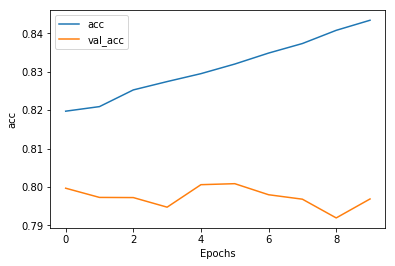

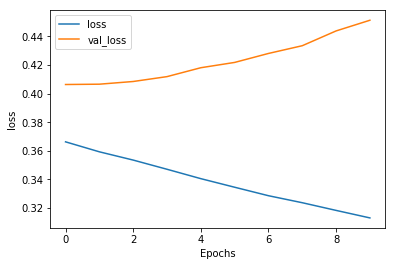

In [105]:
plot_graphs(history, "acc")
plot_graphs(history, "loss")

In [106]:
e = model.layers[0]
weights = e.get_weights()[0]

weights.shape

(10000, 16)

In [0]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [0]:
import io

out_v = io.open('ko-vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('ko-meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

## [TensorBoard](http://projector.tensorflow.org/)